In [141]:
import uproot
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

file = uproot.open("TestFiles.root")
tree = file["TestTree"]

eventid = tree.array("eventId")
pfoid = tree.array("pfoId")
wdrift = tree.array("hitDriftPositionsW")
wwire = tree.array("hitWirePositionsW")
particles = len(pfoid)
purity = tree.array("purity")
completeness = tree.array("completeness")
pdg = tree.array("bestMCParticlePdgCode")
wenergies = tree.array("hitEnergiesW")
whits = tree.array("nHitsInBestMCParticleW")
istrack = tree.array("bestMCParticleIsTrack")
hitEnergiesW = tree.array('hitEnergiesW')
nHitsW = tree.array('nHitsInPfoW')

## Get identities of good pfos

In [2]:
comppureid = np.intersect1d(np.where(completeness > 0.9),np.where(purity > 0.9))
goodhits = []
for i in range(particles):
    if len(wwire[i]) > 5:
        goodhits.append(i)
trueid = np.intersect1d(comppureid,goodhits)

# Tracks and showers

In [3]:
pfo_hits = np.array([ len(x) for x in wwire])
trackid = np.where((completeness > 0.9) & (purity > 0.9) & (pfo_hits > 5) & (istrack == 1))
showerid = np.where((completeness > 0.9) & (purity > 0.9) & (pfo_hits > 5) & (istrack == 0))
piplus = np.where((completeness > 0.9) & (purity > 0.9) & (pfo_hits > 5) & (pdg == 211))
piminus = np.where((completeness > 0.9) & (purity > 0.9) & (pfo_hits > 5) & (pdg == -211))
muon = np.where((completeness > 0.9) & (purity > 0.9) & (pfo_hits > 5) & (pdg == 13))
antimuon = np.where((completeness > 0.9) & (purity > 0.9) & (pfo_hits > 5) & (pdg == -13))
proton = np.where((completeness > 0.9) & (purity > 0.9) & (pfo_hits > 5) & (pdg == 2212))
neutron = muon = piplus = np.where((completeness > 0.9) & (purity > 0.9) & (pfo_hits > 5) & (pdg == 2112))

In [4]:
hit_energies_sum = hitEnergiesW.sum()

In [39]:
hit_energies_sum_tracks = hit_energies_sum[trackid]
hit_energies_sum_showers = hit_energies_sum[showerid]

## Regress the lines of best fit

In [5]:
#Find means in wire and drift for each pfo
wireav = wwire[trueid].mean()
driftav = wdrift[trueid].mean()

#Find slope and intercept of lines of best fit
driftdiff = wdrift[trueid] - driftav
wirediff = wwire[trueid] - wireav
driftwire = driftdiff*wirediff
driftsq = driftdiff**2
nume = driftwire.sum()
denom = driftsq.sum()
slope = nume/denom
intercept = wireav - slope*driftav
slopezero = np.where(slope==0.0)

## First and last points of each pfo

In [6]:
wwire_sorted = []
wdrift_sorted = []

for i in range(len(wwire)):
    wwire_sorted.append(np.sort(wwire[i]))
    
for i in range(len(wdrift)):
    wdrift_sorted.append(np.sort(wdrift[i]))

In [7]:
wwirestart = []
wwireend = []
wdriftstart = []
wdriftend = []
for i in trueid:
    wwirestart.append(wwire_sorted[i][0])
    wwireend.append(wwire_sorted[i][-1])
    wdriftstart.append(wdrift_sorted[i][0])
    wdriftend.append(wdrift_sorted[i][-1])

## Regress end points to line of best fit

In [8]:
xstart = []
xend = []
ystart = []
yend = []
for i in range(len(trueid)):
    if slope[i] != 0:
        slopeinv = -1.0/slope[i]
        startintercept = wwirestart[i] - wdriftstart[i]*slopeinv
        endintercept = wwireend[i] - wdriftend[i]*slopeinv
        xbegin = (startintercept - intercept[i])/(slope[i] - slopeinv)
        ybegin = slope[i]*xbegin + intercept[i]
        xfinish = (endintercept - intercept[i])/(slope[i]-slopeinv)
        yfinish = slope[i]*xfinish + intercept[i]
        xstart.append(xbegin)
        xend.append(xfinish)
        ystart.append(ybegin)
        yend.append(yfinish)
    else:
        xstart.append(wdriftstart[i])
        xend.append(wdriftend[i])
        ystart.append(wwirestart[i])
        yend.append(wwireend[i])
        

# Line lengths

In [9]:
linelength = []
for i in range(len(xstart)):
    xdiff = xend[i] - xstart[i]
    ydiff = yend[i] - ystart[i]
    lensq = xdiff**2 +ydiff**2
    length = np.sqrt(lensq)
    linelength.append(length)

In [10]:
track_pfo_energies = hitEnergiesW[trackid]
shower_pfo_energies = hitEnergiesW[showerid]

In [11]:
piplus_energies = hitEnergiesW[piplus]
piminus_energies = hitEnergiesW[piminus]
muon_energies = hitEnergiesW[muon]
antimuon_energies = hitEnergiesW[antimuon]
proton_energies = hitEnergiesW[proton]
neutron_energies = hitEnergiesW[neutron]

# Regress all pfo points to line gosh this took 5ever

In [14]:
xpoints = []
ypoints = []
for i in range(len(trueid)):
    xcoord = []
    ycoord = []
    a = trueid[i]
    if slope[i] == 0.0:
        xcoord.append(wdrift[a])
        ycoord.append(wwire[a])
    else:
        for j in range(len(wwire[a])):
            slopeinv = -1.0/slope[i]
            pointintercept = wwire[a][j] - wdrift[a][j]*slopeinv
            xpoint = (pointintercept - intercept[i])/(slope[i] - slopeinv)
            ypoint = slope[i]*xpoint + intercept[i]
            xcoord.append(xpoint)
            ycoord.append(ypoint)
    xpoints.append(xcoord)
    ypoints.append(ycoord)

print(len(xpoints[1]))
print(len(wdrift[trueid[1]]))

117
117


# Normalise positions of regressed points for banter

In [15]:
pointsnorm = []
for i in range(len(trueid)):
    pointcoordnorm = []
    for j in range(len(xpoints[i])):
        xdifference = xpoints[i][j] - xpoints[i][0]
        lengf = xpoints[i][-1] - xpoints[i][0]
        normlength = xdifference/lengf
        pointcoordnorm.append(normlength)
    pointsnorm.append(pointcoordnorm)

C:\Users\r.xavier\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


# Order those regressed points along the line praise be to argsort

In [16]:
pointorder = []
for i in range(len(trueid)):
    lengthorder = np.argsort(pointsnorm[i])
    pointorder.append(lengthorder)

# Reorganise regressed points according to position, not gender or race

In [17]:
xpointsorder = []
ypointsorder = []
for i in range(len(trueid)):
    xpfosort = [xpoints for _,xpoints in sorted(zip(pointorder[i],xpoints[i]))]
    ypfosort = [ypoints for _,ypoints in sorted(zip(pointorder[i],ypoints[i]))]
    xpointsorder.append(xpfosort)
    ypointsorder.append(ypfosort)

# Find new lengths due to reordered points.

In [18]:
truelinelength = []
for i in range(len(xstart)):
    xdiff = xpointsorder[i][-1] - xpointsorder[i][0]
    ydiff = ypointsorder[i][-1] - ypointsorder[i][0]
    lensq = xdiff**2 + ydiff**2
    length = np.sqrt(lensq)
    truelinelength.append(length)

# Find new normalised point positions 

In [19]:
truepointsnorm = []
for i in range(len(trueid)):
    truepointcoordnorm = []
    a = trueid[i]
    for j in range(len(xpointsorder[i])):
        xdifference = xpointsorder[i][j] - xpointsorder[i][0]
        ydifference = ypointsorder[i][j] - ypointsorder[i][0]
        lengthsq = xdifference**2 + ydifference**2
        truelen = np.sqrt(lengthsq)
        normlength = truelen/truelinelength[i]
        truepointcoordnorm.append(normlength)
    truepointsnorm.append(truepointcoordnorm)

C:\Users\r.xavier\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


# Indices of hits that are > 0.8 along the line

In [20]:
truepoints_tracks = []
truepoints_showers = []

for i in range(len(truepointsnorm)):
    a = trueid[i]
    if a in trackid[0]:
        truepoints_tracks.append(truepointsnorm[i])
    elif a in showerid[0]:
        truepoints_showers.append(truepointsnorm[i])

In [21]:
truepointsTracks=np.array([np.array(i) for i in truepoints_tracks])
truepointsShowers=np.array([np.array(i) for i in truepoints_showers])

In [22]:
end_indices_tracks = []

for i in range(len(trackid[0])):
    end_indices_tracks.append(np.array(np.where(truepointsTracks[i] > 0.8)))

C:\Users\r.xavier\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


In [23]:
#Track energies in final 20%

end_track_energies = []

for i in range(len(track_pfo_energies)):
    end_track_energies.append(np.array(track_pfo_energies[i][end_indices_tracks[i]]))

In [102]:
end_track_energies_sum = []

for i in range(len(trackid[0])):
    end_track_energies_sum.append(end_track_energies[i].sum())

In [103]:
#Fraction of the total PFO energy contained in hits in the final 20%

energy_frac_tracks = end_track_energies_sum / hit_energies_sum_tracks

In [79]:
end_indices_showers = []

for i in range(len(showerid[0])):
    end_indices_showers.append(np.array(np.where(truepointsShowers[i] > 0.8)))

In [80]:
end_shower_energies = []

for i in range(len(showerid[0])):
    end_shower_energies.append(shower_pfo_energies[i][end_indices_showers[i]])

In [106]:
end_shower_energies_sum = []

for i in range(len(showerid[0])):
    end_shower_energies_sum.append(end_shower_energies[i].sum())

In [108]:
energy_frac_showers = end_shower_energies_sum / hit_energies_sum_showers

In [111]:
weight_tracks = np.ones_like(av_energy_frac_tracks) / len(av_energy_frac_tracks)
weight_showers = np.ones_like(av_energy_frac_showers) / len(av_energy_frac_showers)

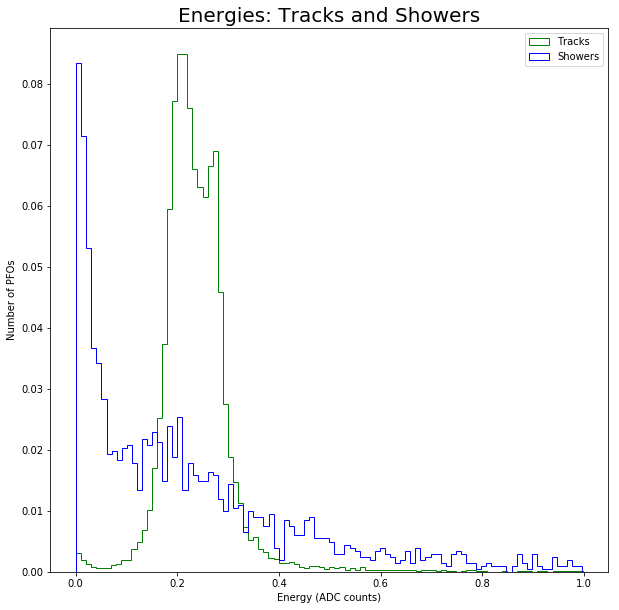

In [152]:
fig = plt.figure(1, figsize=(10, 10))
plt.hist(energy_frac_tracks, 100, weights = weight_tracks, color = 'g', histtype = u'step', label = 'Tracks')
plt.hist(energy_frac_showers, 100, weights = weight_showers, color = 'b', histtype = u'step', label = 'Showers')
plt.title('Energies: Tracks and Showers', fontsize = 20)
plt.xlabel('Energy (ADC counts)')
plt.ylabel('Number of PFOs')

plt.legend()
        
plt.show()

In [146]:
len(trueid)

24098